<a href="https://colab.research.google.com/github/meghutch/Breast-Cancer-Classification-Clinical-Genomic/blob/master/Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Clinical Outcomes of Breast Cancer Patients**

## **Neural Networks and PCA**

**Author:** Meg Hutch

**Date:** November 27, 2019

**Objective:** Integrate the Principal Components from the **Gene Expression Analysis - PCA**. 

These were the Principal Components explaining 90% of the variance. 

Unlike the **Neural_Network_Clinical_Outcomes** analysis, this will use the patients in the merged_expression.txt that were processed.

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [86]:
# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import Data
# Merged Expression Data
gene_data = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Data/merged_expression.txt', sep=',')

## Principal Component Data
# All Principal Components
pc_all = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/gene_pca_components_All_1747.txt')

# Principal Components Responsible for 90% of the variation
pc_90 = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/gene_pca_components_90.txt')

# **Data Pre-Processing**

Check if there are missing values and add the event label to the prinicipal component dataframes

**Check if there are any missing values**

In [88]:
gene_data.isna().any()

Unnamed: 0    False
EVENT          True
OS_MONTHS     False
FIVE_YEAR      True
RERE          False
              ...  
CC2D1A        False
CB986545      False
IGSF9         False
DA110839      False
FAM71A         True
Length: 24372, dtype: bool

**Remove observations with missing values**

In [0]:
gene_data = gene_data.dropna()

**Check Final Number of Patients**

In [90]:
gene_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 0 to 1903
Columns: 24372 entries, Unnamed: 0 to FAM71A
dtypes: float64(24371), object(1)
memory usage: 324.9+ MB


**Add Outcome Variable to the PC Dataframes**

In [0]:
# Subset only the Event - whether they lived (0) or died (1) from Breast Cancer
labels = gene_data.EVENT

# Create a list of row names
patients = list(gene_data.index)

# Convert labels into a dataframe and indicate patients as the index
labels = pd.DataFrame(labels, index = patients)

# Create a row ID from the row names 
#labels['ID'] = np.arange(len(labels))

pc_all = pc_all.set_index('Unnamed: 0')
pc_90 = pc_90.set_index('Unnamed: 0')

# Remove the index name (Unnamed: 0)
pc_all.index.name = None
pc_90.index.name = None

# Add labels to the pc dataframes
pc_all = pd.merge(pc_all, labels, left_index=True, right_index=True)
pc_90 = pd.merge(pc_90, labels, left_index=True, right_index=True)

# **Predict Outcomes Using Gene Expression Principal Components**

We will attempt to predict Event (1 = died from breast cancer, 0 = alive), using the following classification methods and only using Principal Components as features

* Logistic Regression
* Random Forest
* Neural Networks. 

Logistic regression and random forest classiers can help serve as a benchmark of performance once we develop our neural network classifier.

# **Training and Testing Split**

For all of our classification methods, we will create a training and a testing set.

In [0]:
# Packagess
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Format the pc data into a features and label dataframe. EVENT indicates that the patient died from disease. 

In [0]:
# Let x represent the input features; y the labels

# Want to remove EVENT from inputs since these are what we are trying to predict. Event will remain as our label.

# create x to represent the input features; y is the label
x = pc_90.drop(['EVENT'], axis=1)
y = pc_90.EVENT

Split the data into testing and training sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=15)

View the shapes of the training and testing sets; the datasets ending in "train" are our training sets; similarly, those ending in "test" are the testing; x prefix always represents the input features, y the labels

In [95]:
# Assess the trainig and testing sets previously created
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1310, 1213)
Training Labels Shape: (1310,)
Testing Features Shape: (437, 1213)
Testing Labels Shape: (437,)


Examine the class distributions - these are similar splits between the training and testing sets. This is also representative of the number of cases throughout the entire dataset. 

Overall, 35% of the patients in our total data died from disease. So this is an unbalanced dataset and a few percents off from the splits in the training/testing set. **Not sure if this is a problem?**

In [96]:
# Died from disease
print('Died of Diseases in Training Set:', np.count_nonzero(y_train == 1))
print('Died of Diseases in Testing Set:', np.count_nonzero(y_test == 1))

# Percents
print('% Died of Diseases Cases in Training Set:', round(np.count_nonzero(y_train == 1)/1139*100,2))
print('% Died of Diseases Cases in Testing Set:', round(np.count_nonzero(y_test == 1)/380*100,2))

# Died of disease overall
print('Died of Diseases Overall:', np.count_nonzero(pc_90 == 1))
print('% Died of Diseases Overall:', round(np.count_nonzero(pc_90 == 1)/1747*100,2))

Died of Diseases in Training Set: 470
Died of Diseases in Testing Set: 150
% Died of Diseases Cases in Training Set: 41.26
% Died of Diseases Cases in Testing Set: 39.47
Died of Diseases Overall: 620
% Died of Diseases Overall: 35.49


# **Logistic Regression**

Because we don't want to overfit the logistic regression model or have problems with convergence, we will follow the 1 in 10 rule, where we only have 1 predictor per 10 samples in the outcome of interest class (in our case 620 patients who died = 62 predictors/prinicipal components). 

Logistic Regression steps were followed from the following tutorial:

https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

**Select the top 62 Prinicipal Components**

In [0]:
X_train_62 = X_train.iloc[:,0:62]
X_test_62 = X_test.iloc[:,0:62]

**Define and Run the Model**

In [98]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_62, y_train)

y_pred = logreg.predict(X_test_62)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [99]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[230,  57],
       [100,  50]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [100]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

Accuracy: 0.641
Precision: 0.467
Recall: 0.333


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

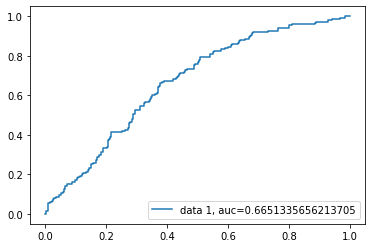

AUC: 0.665


In [101]:
y_pred_proba = logreg.predict_proba(X_test_62)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

Fairly low sensitivity (Recall) = 33%; but the accuracy is fairly impressive that we can predict survivial just using 62 prinicipal components. This actually has better recall then the logistic regression performed with just clinical data. Additionally, the AUCs were both 67%. **Note: Keep in mind that the clinical data results I'm comparing it too, were used with a different testing/training split. 

I wll have re-run the neural network on this data to properly assess  

**How much of the variance do the top 62 prinicipal components contribute?**

From the chart below, we can see that pc62 contribute up to ~41% of the variance. 

In [102]:
# import table of variances
var_chart = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/component_variance_chart_90.txt', sep=',', index_col=0)
var_chart[:62] 

,% Variance,CumulativeVariance
pc1,6.5,6.5
pc2,4.4,10.9
pc3,3.2,14.1
pc4,2.4,16.5
pc5,2.1,18.6
...,...,...
pc58,0.2,40.1
pc59,0.2,40.3
pc60,0.2,40.5
pc61,0.2,40.7


# **Assess increasingly lower numbers of Principal Components**

Identify the number of principal components to represent 35, 30, 25, and 20% of varaince, and compare performance with the top 62 principal components. 

In [0]:
pc_35 = var_chart[var_chart.CumulativeVariance <= 35] # 33 components

pc_30 = var_chart[var_chart.CumulativeVariance <= 30] # 17 components

pc_25 = var_chart[var_chart.CumulativeVariance <= 25] # 9 components

pc_20 = var_chart[var_chart.CumulativeVariance <= 20] # 5 components

**Logistic Regression - PC 35% of variance**

33 prinicipal components

Confusion Matrix [[239  48]
 [100  50]]
Accuracy: 0.661
Precision: 0.51
Recall: 0.333


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


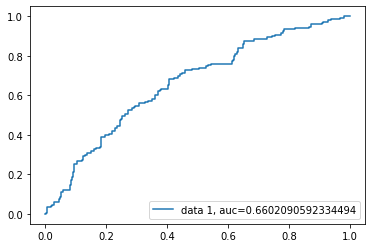

AUC: 0.66


In [104]:
# Split the training/testing sets
X_train_33 = X_train.iloc[:,0:33]
X_test_33 = X_test.iloc[:,0:33]

## Define and run the model
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_33, y_train)
y_pred = logreg.predict(X_test_33)

## Evaluate model 
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix', cnf_matrix)

# Assess accuracy, precision, recall
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

# Calculate ROC
y_pred_proba = logreg.predict_proba(X_test_33)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**Logistic Regression - PC 30% of variance**

17 prinicipal components

Confusion Matrix [[246  41]
 [108  42]]
Accuracy: 0.659
Precision: 0.506
Recall: 0.28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


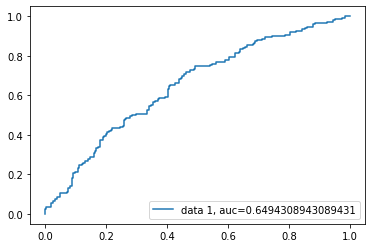

AUC: 0.649


In [105]:
# Split the training/testing sets
X_train_17 = X_train.iloc[:,0:17]
X_test_17 = X_test.iloc[:,0:17]

## Define and run the model
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_17, y_train)
y_pred = logreg.predict(X_test_17)

## Evaluate model 
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix', cnf_matrix)

# Assess accuracy, precision, recall
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

# Calculate ROC
y_pred_proba = logreg.predict_proba(X_test_17)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**Logistic Regression - PC 25% of variance**

9 prinicipal components

Confusion Matrix [[266  21]
 [129  21]]
Accuracy: 0.657
Precision: 0.5
Recall: 0.14


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


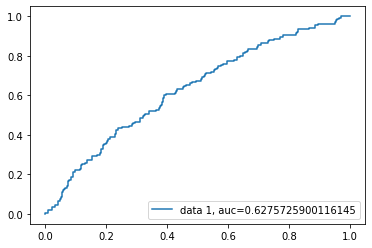

AUC: 0.628


In [106]:
# Split the training/testing sets
X_train_9 = X_train.iloc[:,0:9]
X_test_9 = X_test.iloc[:,0:9]

## Define and run the model
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_9, y_train)
y_pred = logreg.predict(X_test_9)

## Evaluate model 
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix', cnf_matrix)

# Assess accuracy, precision, recall
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

# Calculate ROC
y_pred_proba = logreg.predict_proba(X_test_9)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

**Logistic Regression - PC 20% of variance**

5 prinicipal components

Confusion Matrix [[272  15]
 [138  12]]
Accuracy: 0.65
Precision: 0.444
Recall: 0.08


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


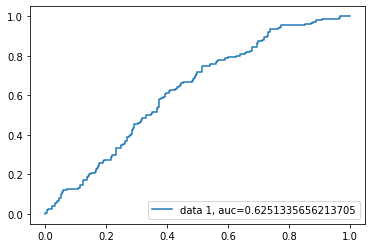

AUC: 0.625


In [107]:
# Split the training/testing sets
X_train_5 = X_train.iloc[:,0:5]
X_test_5 = X_test.iloc[:,0:5]

## Define and run the model
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_5, y_train)
y_pred = logreg.predict(X_test_5)

## Evaluate model 
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix', cnf_matrix)

# Assess accuracy, precision, recall
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

# Calculate ROC
y_pred_proba = logreg.predict_proba(X_test_5)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

# **Logistic Regression Results**

**Table of Logistic Regression Results**

**62 Prinicipal Components (41%) of the variance**
* Accuracy: 0.641
* Precision: 0.467
* Recall: 0.333
* AUC: 0.665

**33 Prinicipal Components (35%) of the variance**
* Accuracy: 0.661
* Precision: 0.51
* Recall: 0.333
* AUC: 0.660

**17 Prinicipal Components (30%) of the variance**
* Accuracy: 0.659
* Precision: 0.506
* Recall: 0.28
* AUC: 0.649

**9 Prinicipal Components (25%) of the variance**
* Accuracy: 0.657
* Precision: 0.5
* Recall: 0.14
* AUC: 0.628

**5 Prinicipal Components (20%) of the variance**
* Accuracy: 0.65
* Precision: 0.444
* Recall: 0.08
* AUC: 0.625

As we can see, recall and AUC continue to decrease when we test under 33 prinicipal components. Intersetingly, 33 prinicipal components seems to perform simiarly to 62 prinicipal components. For instance, recall is the same, and the AUC is only slightly lower with 33 componenets. 

# **Random Forest Classification**

We assess the performance of a random forest classifier using 1213 prinicipal components (those found responsible for 90% of the variance), 62 and 33 prinicipal components. 

**Is there an upper limit on the number of predictors in a random forest model?**

References:  https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 and https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

**1213 Prinicipal Components (90% of the Variance)**

**Train the Model**

In [24]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel # to identify features

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Select Important Features**

Identify which Principal Components contributed most to the model

550
Index(['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc7', 'pc8', 'pc9', 'pc10', 'pc12',
       ...
       'pc1201', 'pc1203', 'pc1204', 'pc1205', 'pc1207', 'pc1208', 'pc1209',
       'pc1210', 'pc1211', 'pc1212'],
      dtype='object', length=550)


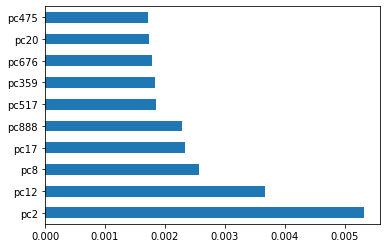

In [25]:
# First feature selection test
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat)) 
print(selected_feat)

## histogram of the top 10 pc by importance
# create a list of features/column names
features = list(X_train.columns.values) 

feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)  
feat_importances.nlargest(10).plot(kind='barh')

** **I should ask about this: The finding above is intersting because though PC1 is said to explain the most variance, it is not even in the plot of the top 10 prinicipal components the random forest found to be of importance. Though PC2 is implicated as being the most important** **

**Make Predictions on the Test Set**

In [26]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.34


**Evaluating the Performance**

For Classification Problems the metrics used to evaluate an algorithm are accuracy, confusion matrix, precision, recall, and F1 values.

We can also perform cross-fold validation to have a better understanding of the results

Reference: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652 

**ROC on the Full Data**


We make class predictions (predict) as well as predicted probabilities (predict_proba) to calculate the ROC AUC. Once we have the testing predictions, we can calculate the ROC AUC. https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [31]:
from sklearn.metrics import roc_auc_score
# Calculate ROC AUC
roc_value = roc_auc_score(y_test, rf_probs) 
roc_value

0.5944134727061556

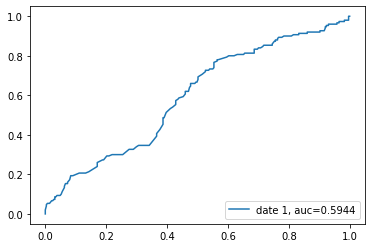

In [32]:
# Probabilities for each class
# Note from scikit learn: re fpr and tpr: "Since the thresholds are sorted from low to high values, they are reversed upon returning them to ensure they correspond to both fpr and tpr, which are sorted in reversed order during their calculation."
rf_probs = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_probs)
auc = metrics.roc_auc_score(y_test, rf_probs)
auc = round(auc, 4)
plt.plot(fpr, tpr, label="date 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**10 Cross-Fold Validation**

In [0]:
rfc_cv_score = cross_val_score(rf, x, y, cv=10, scoring='roc_auc') 

Below, we also can examine the confusion matrix, the classification report containing precision, recall, f1-score, and support, All AUC scores, and the mean AUC score

The **confusion matrix** is useful for giving false positives and false negatives

The **ROC Curve** plots out the true positive rate vs the false positive rate at various thresholds

The **ROC AUC Scoring** used in the cross-validation model shows the area under the ROC curve

In [34]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", accuracy_score(y_test, predictions))

=== Confusion Matrix ===
[[287   0]
 [150   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       287
         1.0       0.00      0.00      0.00       150

    accuracy                           0.66       437
   macro avg       0.33      0.50      0.40       437
weighted avg       0.43      0.66      0.52       437



=== All AUC Scores ===
[0.6203968  0.62417927 0.55002855 0.65772195 0.49500428 0.55174136
 0.56722809 0.58071717 0.62903226 0.62644009]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.5902489830145589


=== Accuracy Score ===
Accuracy: 0.6567505720823799


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It looks like 1213 PC may be too many for us to analyze -- we get a recall of 0 -- this actually makes me wonder if I messed something up with the code? 

**62 Prinicipal Components (41% of the Variance)**

**Train the Model**

In [68]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel # to identify features

# Instantiate model with 1000 decision trees - results below reported w/ random state = 42
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train_62, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Select Important Features**

Identify which Principal Components contributed most to the model

23
Index(['pc1', 'pc2', 'pc3', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc12',
       'pc17', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc26', 'pc33', 'pc35',
       'pc42', 'pc47', 'pc50', 'pc60'],
      dtype='object')


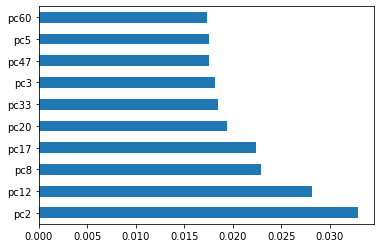

In [69]:
# First feature selection test
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train_62, y_train)
sel.get_support()
selected_feat= X_train_62.columns[(sel.get_support())]
print(len(selected_feat)) 
print(selected_feat)

## histogram of the top 10 pc by importance
# create a list of features/column names
features = list(X_train_62.columns.values) 

feat_importances = pd.Series(rf.feature_importances_, index=X_train_62.columns)  
feat_importances.nlargest(10).plot(kind='barh')

** **I should ask about this: The finding above is intersting because though PC1 is said to explain the most variance, it is not even in the plot of the top 10 prinicipal components the random forest found to be of importance. Though PC2 and PC3 reside in the top 10!** **

**Make Predictions on the Test Set**

In [70]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test_62)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test_62)[:, 1]

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.36


**Evaluating the Performance**

For Classification Problems the metrics used to evaluate an algorithm are accuracy, confusion matrix, precision, recall, and F1 values.

We can also perform cross-fold validation to have a better understanding of the results

Reference: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652 

**ROC on the Full Data**


We make class predictions (predict) as well as predicted probabilities (predict_proba) to calculate the ROC AUC. Once we have the testing predictions, we can calculate the ROC AUC. https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [72]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC
roc_value = roc_auc_score(y_test, rf_probs) 
roc_value

0.6376655052264809

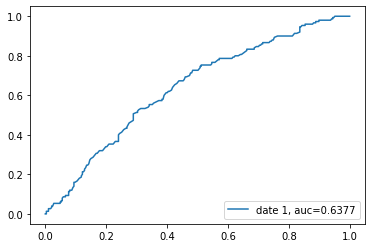

In [73]:
# Probabilities for each class
# Note from scikit learn: re fpr and tpr: "Since the thresholds are sorted from low to high values, they are reversed upon returning them to ensure they correspond to both fpr and tpr, which are sorted in reversed order during their calculation."
rf_probs = rf.predict_proba(X_test_62)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_probs)
auc = metrics.roc_auc_score(y_test, rf_probs)
auc = round(auc, 4)
plt.plot(fpr, tpr, label="date 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**10 Cross-Fold Validation**

In [0]:
# need to combine the testing and training sets to perform cross-fold varlidation
# select the 62 pc columns
x_62 = x.iloc[:,0:62]
y_62 = y

rfc_cv_score = cross_val_score(rf, x_62, y_62, cv=10, scoring='roc_auc') 

Below, we also can examine the confusion matrix, the classification report containing precision, recall, f1-score, and support, All AUC scores, and the mean AUC score

The **confusion matrix** is useful for giving false positives and false negatives

The **ROC Curve** plots out the true positive rate vs the false positive rate at various thresholds

The **ROC AUC Scoring** used in the cross-validation model shows the area under the ROC curve

In [75]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", accuracy_score(y_test, predictions))

=== Confusion Matrix ===
[[267  20]
 [136  14]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.66      0.93      0.77       287
         1.0       0.41      0.09      0.15       150

    accuracy                           0.64       437
   macro avg       0.54      0.51      0.46       437
weighted avg       0.58      0.64      0.56       437



=== All AUC Scores ===
[0.62432201 0.6131887  0.63281473 0.70147017 0.6107622  0.57493577
 0.55959178 0.58518145 0.56127592 0.76281682]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6226359548958036


=== Accuracy Score ===
Accuracy: 0.6430205949656751


**33 Prinicipal Components (35% of the Variance)**

**Train the Model**

In [76]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel # to identify features

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42) # results below reported w/ random state = 42

# Train the model on training data
rf.fit(X_train_33, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Select Important Features**

Identify which Principal Components contributed most to the model

11
Index(['pc1', 'pc2', 'pc3', 'pc5', 'pc6', 'pc8', 'pc12', 'pc17', 'pc21',
       'pc29', 'pc33'],
      dtype='object')


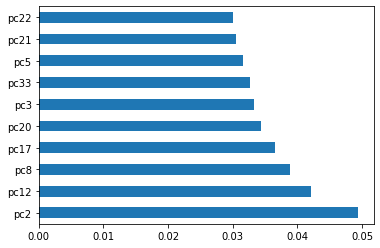

In [77]:
# First feature selection test
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train_33, y_train)
sel.get_support()
selected_feat= X_train_33.columns[(sel.get_support())]
print(len(selected_feat)) 
print(selected_feat)

## histogram of the top 10 pc by importance
# create a list of features/column names
features = list(X_train_33.columns.values) 

feat_importances = pd.Series(rf.feature_importances_, index=X_train_33.columns)  
feat_importances.nlargest(10).plot(kind='barh')

** **I should ask about this: The finding above is intersting because though PC1 is said to explain the most variance, it is not even in the plot of the top 10 prinicipal components the random forest found to be of importance. PC2 and PC3 were found in the top 10 in this test.** **

**Make Predictions on the Test Set**

In [78]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test_33)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test_33)[:, 1]

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.33


**Evaluating the Performance**

For Classification Problems the metrics used to evaluate an algorithm are accuracy, confusion matrix, precision, recall, and F1 values.

We can also perform cross-fold validation to have a better understanding of the results

Reference: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652 

**ROC on the Full Data**


We make class predictions (predict) as well as predicted probabilities (predict_proba) to calculate the ROC AUC. Once we have the testing predictions, we can calculate the ROC AUC. https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [80]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC
roc_value = roc_auc_score(y_test, rf_probs) 
roc_value

0.6287224157955866

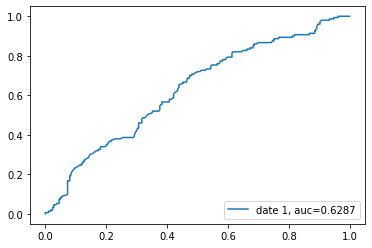

In [81]:
# Probabilities for each class
# Note from scikit learn: re fpr and tpr: "Since the thresholds are sorted from low to high values, they are reversed upon returning them to ensure they correspond to both fpr and tpr, which are sorted in reversed order during their calculation."
rf_probs = rf.predict_proba(X_test_33)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_probs)
auc = metrics.roc_auc_score(y_test, rf_probs)
auc = round(auc, 4)
plt.plot(fpr, tpr, label="date 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**10 Cross-Fold Validation**

In [0]:
# need to combine the testing and training sets to perform cross-fold varlidation
# select the 33 pc columns
x_33 = x.iloc[:,0:33]
y_33 = y

rfc_cv_score = cross_val_score(rf, x_33, y_33, cv=10, scoring='roc_auc') 

Below, we also can examine the confusion matrix, the classification report containing precision, recall, f1-score, and support, All AUC scores, and the mean AUC score

The **confusion matrix** is useful for giving false positives and false negatives

The **ROC Curve** plots out the true positive rate vs the false positive rate at various thresholds

The **ROC AUC Scoring** used in the cross-validation model shows the area under the ROC curve

In [83]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", accuracy_score(y_test, predictions))

=== Confusion Matrix ===
[[262  25]
 [118  32]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.69      0.91      0.79       287
         1.0       0.56      0.21      0.31       150

    accuracy                           0.67       437
   macro avg       0.63      0.56      0.55       437
weighted avg       0.65      0.67      0.62       437



=== All AUC Scores ===
[0.61754211 0.61411647 0.59877248 0.7471453  0.62553526 0.56408792
 0.57800457 0.60224654 0.53096198 0.77491359]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6253326230577871


=== Accuracy Score ===
Accuracy: 0.6727688787185355


# **Random Forest Results**

**Table of Random Forest Results**

**1213 Prinicipal Components (90%) of the variance**

I am not going to include these results -- Recall was 0

**62 Prinicipal Components (41%) of the variance**

* AUC: 0.637
* Mean Absolute Error: 0.36
* Accuracy: 0.643
* Mean AUC from 10 CFV: 0.62
                   === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.66      0.93      0.77       287
         1.0       0.41      0.09      0.15       150
       accuracy                        0.64       437
       macro avg   0.54      0.51      0.46       437
      weighted avg 0.58      0.64      0.56       437 

Sensitivity is very low with this method.

**33 Prinicipal Components (35%) of the variance**
* AUC: 0.623
* Mean Absolute Error: 0.33
* Accuracy: 0.67
* Mean AUC from 10 CFV: 0.67

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.69      0.91      0.79       287
         1.0       0.56      0.21      0.31       150
       accuracy                        0.67       437
       macro avg   0.63      0.56      0.55       437
      weighted avg 0.65      0.67      0.62       437


Overall, it does not look like we can expect good results with all 1213 Prinicipal Components. Additionally, AUCs and recall were better in the logistic regression models. 

Suprisingly, Recall was higher when testing 33 prinicipal components with a random forest classifier. I wonder if may that was just by chance.

**Note:** I changed the random see for pc_33 random forest results because I wanted to assess whether or not we'd get the same recall. Thus, the actual results may be slightly different from what was reported in this results chunk. **Update:** Recall is still 0.17. 

I also tried changing random number see for 62 prinicpal components, and the recall was .10 ~~ so looks like perhaps 33 prinicipal components performs better with random forests -- although more tests would help ensure this. 

**One thing to maybe look into is changing the number of trees. I wonder if this would improve results at all.**

# **Neural Network Classification**

In [0]:
# Import PyTorch packages
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

**Assess Neural Network Classification Using all 1213 Prinicipal Components**

**Format the Training Dataset**

In [0]:
# Convert data into arrays
xb = np.array(X_train, dtype = "float32")
yb = np.array(y_train, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Combine the arrays
trainloader = TensorDataset(xb, yb)

# Define the batchsize
batch_size = 32

# Training Loader
trainloader = DataLoader(trainloader, batch_size, shuffle=True)

**Format the Testing Dataset**

In [0]:
# Convert data into arrays
xb = np.array(X_test, dtype = "float32")
yb = np.array(y_test, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Combine the arrays
testloader = TensorDataset(xb, yb) 

# Define the batchsize
batch_size= 32

# Training Loader
testloader = DataLoader(testloader, batch_size, shuffle=True) 

**Create Neural Network Model**

In [188]:
# Define the model with hidden layers - 1213 inputs
model = nn.Sequential(nn.Linear(1213, 500),
                      nn.ReLU(),
                      nn.Linear(500, 10),
                      nn.ReLU(),
                      nn.Linear(10, 1), 
                      nn.Sigmoid())
                      
# Set optimizer and learning rate
#optimizer = optim.SGD(model.parameters(), lr=0.003)

# Could also use Adam optimizer; similar to stochastic gradient descent, but uses momentum which can speed up the actual fitting process, and it also adjusts the learning rate for each of the individual parameters in the model
optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.BCELoss() # use with a sigmoid function

#criterion = nn.CrossEntropyLoss() #don't use with softmax or sigmoid

# Set epochs
epochs = 50
for e in range(epochs):
    running_loss = 0
    for xb, yb in trainloader:
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Training pass
        output = model.forward(xb)
        loss = criterion(output, yb) # Loss calculated from the output compared to the labels  
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. Running_loss = 0, 
        # += notation, says "Add a value and the variable and assigns the result to that variable." So, adds the running_loss (0) with loss.item and assigns to running_loss
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss: 0.694236662329697
Training loss: 0.5331924441384106
Training loss: 0.4297968534434714
Training loss: 0.337454311731385
Training loss: 0.2595346664510122
Training loss: 0.19466415483777116
Training loss: 0.1418824183141313
Training loss: 0.10177292711124188
Training loss: 0.07279204813445486
Training loss: 0.05277081860638246
Training loss: 0.03925512022361523
Training loss: 0.029918167603815476
Training loss: 0.0233172762957288
Training loss: 0.018506272786819353
Training loss: 0.0151377339370367
Training loss: 0.012526178664368828
Training loss: 0.010498157940895819
Training loss: 0.00893313712554007
Training loss: 0.007706398416946574
Training loss: 0.006715842181952988
Training loss: 0.005889109881004182
Training loss: 0.005215231113408397
Training loss: 0.00463965997417889
Training loss: 0.00415251206424905
Training loss: 0.0037378439816032967
Training loss: 0.003378791646554884
Training loss: 0.0030686610219318694
Training loss: 0.0028027964347019426
Training loss: 

**Evaluate Model Performance**

=== Confusion Matrix ===
[[214  73]
 [ 86  64]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73       287
         1.0       0.47      0.43      0.45       150

    accuracy                           0.64       437
   macro avg       0.59      0.59      0.59       437
weighted avg       0.63      0.64      0.63       437



=== Accuracy Score ===
Accuracy: 0.636


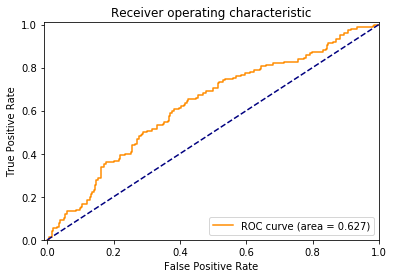

In [189]:
# Convert data into arrays
xb = np.array(X_test, dtype = "float32")
yb = np.array(y_test, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Apply the model to the whole testing dataset
ps = model(xb)

#print('Probabilities', ps[:10])

# Obtain the top probability
top_p, top_class = ps.topk(1, dim=1)
#print('true vals', yb[:10])

# Drop the grad 
top_p = top_p.detach().numpy()
top_class = top_class.detach().numpy()

top_class = (top_p >= 0.5).astype(np.int)
#print('top class', top_class[:10])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(yb, top_p, pos_label=1)

# Compute ROC area
roc_auc = round(auc(fpr, tpr),3)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Classification Report
print("=== Confusion Matrix ===")
print(confusion_matrix(yb, top_class))
print('\n')
print("=== Classification Report ===")
print(classification_report(yb, top_class))
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", round(accuracy_score(yb, top_class),3))

# **Neural Network Experiments**

**December 3 - Neural Network Architecture:**

**Loss:** Binary Cross Entropy Loss

**Activation:** ReLU

**Batchsize:** 32

1) Hidden Layers (500, 10), epochs = 13, Adam, LR = 0.003

AUC = 0.621

                === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.72      0.64      0.68       287
         1.0       0.43      0.51      0.47       150
        accuracy                       0.60       437
        macro avg  0.57      0.58      0.57       437
      weighted avg 0.62      0.60      0.60       437

2) Hidden Layers (500, 10), epochs = 13, Adam, LR = 0.001

AUC = 0.647

                === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73       287
         1.0       0.49      0.48      0.48       150
     accuracy                          0.65       437
     macro avg     0.61      0.61      0.61       437
     weighted avg  0.65      0.65      0.65       437


3) Hidden Layers (500), epochs = 35, Adam, LR = 0.001

AUC = 0.640

4) Hidden layers (500), epochs = 200, Adam, LR = 0.001

AUC = 0.644

5) Hidden layers (500), epochs = 250, Adam, LR = 0.001

AUC = 0.623

5) Hidden layers (500), epochs = 100, Adam, LR = 0.001

AUC = 0.623

# **Next Steps**

* Attempt changing the # of random forest trees   
* Assess the use of neural network classification using principal components - continue looking at this more thoroughly
* Integarate PCs and Clinical data and re-run logistic regressions, random forest, and neural networks. 


